# PointNet with Keras
By Phillip Hungerford

This Notebook is based on the PointNet architecture proposed by Charles R. Qi, Hao Su, Kaichun Mo, Leonidas J. Guibas (https://arxiv.org/abs/1612.00593). The original code is found here https://github.com/charlesq34/pointnet. I made this notebook to help with my dissertation which is on the Prediction of radiotherapy plan violation from spatial arrangement of target and organ at risk structures using deep learning. Upon much research, we agreed that PointNet was a sound architecture to build our model on. This was created to help myself and supervisors to understand the architecture as well as to help others who may need some more detail. 

Before you start, make sure you download the data from here: https://drive.google.com/open?id=1iJEsQUJZj-Dinl-cCz6ijxFxf2bYbQYG 

Be sure to have it in the local directory with the folder name 'data'. 

## 1. Point Clouds
A point cloud is an important type of geometric data structure. It is the closest to 3D representation to raw sensor data and is in a canonical form. This means that we canconvert it to other representations or other representations to point cloud. 

<img src='images/fig1_pointpot.png'>
Fig 1. An example of a point represented through a point cloud.

We can use deep learning techniques to create predictive models on 3D. This is particulary useful for situations like self-driving cars, object classification, segmentation and medical predictions through radiotherapy images. 

## 2. Deep Learning on Point Clouds

### 2.1 Euclidean Data
Deep learning on 3D objects is quite new. Most work has focused on euclidean data. 

<img src='images/fig2_3DDLEUC.png'>

Fig 2. DL models on various Euclidean representations for 3D data.

### 2.2 Non-Euclidean Data
The issue however is that 3D point clouds are non-euclidean and do not have the gridded array structure where there is no global parametrization.


<img src='images/fig3_EUCvNON.png'>
Fig 3. Various representations for 3D data: Euclidean representation (Descriptors, 
Projections, RGB-D, Volumetric; voxels and octree and multi-view) and Non-Euclidean representations (Point clouds, graphs and meshes).

### 2.3 Non-Euclidean to Euclidean
This can be addressed by converting the point clouds into voxels (voxelisation). Once the point cloud has been converted into a voxel, a 3D-CNN can be applied. However, this diminishes important information about the 3D images that have been scanned, renders data unnecessarily voluminous and can cause issues.

<img src='images/fig4_voxelvpcd.png'>
Fig 4. Notice how the voxelised image of the rabbit now loses information regarding space around its ears. 

Voxel 3D-CNN's (VoxNet's) also require large amounts of processing power and increase exponentially has sizes of the voxel grids increase (e.g. 16x16x16 vs 32x32x32 etc). 

A new approach that handles non-euclidean point cloud data for deep learning is called PointNet. This method, 

## 3. PointNet Overview 

PointNet provides a unified architecutre for directly consuming points that can be used for classification, part-segmentation and scene semantic parsing. It was introduced by Charles Qi, Hao Su, Kaichun Mo and Leonidas Guibas from Stanford University in the paper: PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation in 2017. 

<img src='images/pointnet.png'>

To put it simply "[The] key to our approach is the use of a single symmetric function, max pooling. Effectively the network learns a set of optimization functions/criteria that select interesting or informative points of the point cloud and encode the reason for their selection. The final fully connected layers of the network aggregate these learnt optimal values into the global descriptor for the entire shape as mentioned above (shape classification) or are used to predict per point labels (shape segmentation)."

### Main characteristics of PointNet: 
1. Directly consumes point cloud points = (x,y,z). 
2. It respects the permutation invariance of points in the input. Where permutation invariance  means that it does not assume any spatial relationships between the features (our point cloud is permutation invariant because we can plot each point in any order and we would still have the same shape). 

### How does PointNet work? 

<img src='images/fig5_architecture.png'>
Fig 5. The classification network takes n points as input, applies input and feature transformations, and then aggregates point features by max pooling. The output is classification scores for k classes. The segmentation network is an extension to the classification net. It concatenates global and local features and outputs per point scores. “mlp” stands for multi-layer perceptron, numbers in bracket are layer sizes. Batchnorm is used for all layers with ReLU. Dropout layers are used for the last mlp in classification net.

Because we are interested in classification, we will look at this from a classification point of view. Essentially, to break PointNet down:
1. PointNet consumes the points directly
2. Applies non-linear transformations that learn the characteristics of the points and its representation.
3. Finds the underlying skeleton of the transformed image via max-pooling.
4. Applies an MLP on the skeleton to make a prediction. 

<img src='images/fig6_architecturebreakdown.png'>
Fig 6. Simplified representation.

If we break this down, there are 7 steps to PointNet. They are: 
1. Input the data
2. Input transformation
3. MLP 1
4. Feature transformation
5. MLP2 
6. Global feature max-pooling
7. MLP prediction

<img src='images/fig7_architecturenum.png'>
Fig 7. The 7 components of PointNet

For our example we will be using the data that PointNet supplied in their github repository. However, this notebook has imported and will explain all modules and functions as we go. So put your phone on do not disturb, grab a coffee, a snack, light a candle, and go to the toilet before we begin. 

## 0. Lets import the necessary dependencies.

In [56]:
import numpy as np
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils

### For cool 3D interactive visualisations in Jupyter Notebook only (NA for Google Colab)
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

## 1. Input the data (and lets examine it). 

PointNet provide a classification example on the ModelNet40 data. So lets import the files. If you have not imported the files its ok. 

In [57]:
# number of points in each sample
num_points = 2048

# number of categories
k = 40

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

### Training set

In [58]:
train_points_r = np.load('data/train_features.npy')
train_labels_r = np.load('data/train_labels.npy')

### Test set

In [59]:
test_points_r = np.load('data/test_features.npy')
test_labels_r = np.load('data/test_labels.npy')

In [60]:
# label to categorical
Y_train = np_utils.to_categorical(train_labels_r, k)
Y_test = np_utils.to_categorical(test_labels_r, k)

Let's examine the data. 

In [61]:
print("Training shape: ", train_points_r.shape)
print("Test shape: \t", test_points_r.shape)

Training shape:  (9840, 2048, 3)
Test shape: 	 (2468, 2048, 3)


The data is of shape: ( _n_ x number of points x coordinates (x,y,z) ). Here, we can see that we have 9840 samples in our training set and 2468 in our test with each sample (3D object) has 2048 points represented by an x,y,z coordinates.

We can confirm this by doing a simple check on the first image of our training set. 

In [62]:
train_points_r[1]

array([[-0.24544184,  0.3794897 , -0.30967957],
       [-0.41019267,  0.5668479 , -0.30967957],
       [-0.22297175, -0.43689445, -0.30967957],
       ...,
       [-0.06960578, -0.47665146,  0.30498695],
       [ 0.30503637, -0.30395964,  0.30498695],
       [-0.54014397, -0.31866923,  0.20467268]], dtype=float32)

By the looks of this array... you can easily tell that the image is... Ok, we have no idea what this image is by looking at the raw point data. But! We could create a function that plots each point with the matplot library to find out!

In [63]:
!pip3 install matplotlib

In [64]:
# extract 1 image from dataset
first_object = train_points_r[42]
# plot point cloud 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
	
def plot_ply(file):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_zlim(-1,1)
    x=file[:,0]
    y=file[:,1]
    z=file[:,2]
    ax.scatter(x, y, z, marker='.', zdir='z')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

Ok, do not forget this function, it will come in handy when viewing 3D point clouds. So let's have a look at the first object

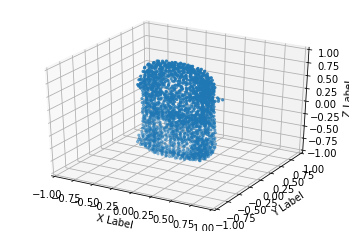

In [65]:
plot_ply(first_object)

Ok... so it looks like a.... I am not sure what it looks like, so lets look at it using an interactive 3D tool. 

In [66]:
# Define x,y,z vectors
X=first_object[:,0]
Y=first_object[:,1]
Z=first_object[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.4))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Example")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

But by the looks of it, it actually looks like a car from this angle. 

In [67]:
train_labels_r[42]

7

Yes we were right! Now we can look at another shape easily. Just enter a number from 0 - 2047 to explore.

This is it in 2D


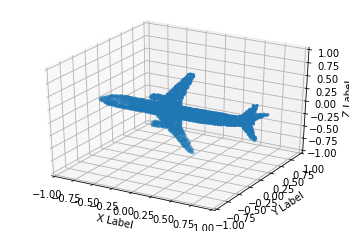

This is a '3D' view


In [68]:
# extract 1 image from dataset
random_number = 698
random_object = train_points_r[random_number]

print("This is it in 2D")
plot_ply(random_object)

print("This is a '3D' view")
# Define x,y,z vectors

X=random_object[:,0]
Y=random_object[:,1]
Z=random_object[:,2]

trace1 = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', 
                      marker=dict(size=10, color=Z, colorscale='Viridis', opacity=0.1))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Example")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 2. The input transformation

The first transformation that occurs is called the input transformation (T-Net 1). This aligns the input point cloud as it can have arbitrary orientations. This is also known as an 'afine transformation'. 

<img src='images/fig8_tnet1.png'>
Fig 8. Transformation network (T-Net) for predicting a transformation matrix to map a point cloud to canonical space before processing. A similar network is used to transform the features; the only difference is that the output corresponds to a 64x64 matrix (T-Net2).

T-Net 1 is found in the 'transform_nets' module. We will create it here for simplicity. This function will take the point clouds as input and a 'is_training' is a placeholder. It will return a transformer, which we will then matrix multiply to the point-clouds and will receive a series of point clouds that will be transformed to account for arbitrary orientations.

From the pointnet_cls module we see the transform applied below.

In [69]:
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu', input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

The first transformation network is a mini-PointNet that takes raw point cloud as input and regresses to a 3 × 3 matrix. It’s composed of a shared MLP (64, 128, 1024) network (with layer output sizes 64, 128, 1024) on each point, a max pooling across points and two fully connected layers with output sizes 512, 256. The output matrix is initialized as an identity matrix. All layers, except the last one, include ReLU and batch normalization. 


## 3. MLP 1: Feature Extraction

The first MLP (technically the 2nd after T-Net) learns important characteristics of our transformed point clouds. As this is the code from the get_model function in the PointNet class we do not need to run it. But we do need to break it down. We can see that an input image (point clouds) are entered into the network with an output size of 64 and kernel size of [1,3]. The actual 'conv2d' function is from tf_utils.

In [70]:
def mat_mul(A, B):
    return tf.matmul(A, B)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

## 4. Feature Transformation: T-Net 2
The second T-Net block is with the same idea, but this time for aligning in the embedding space. The embedding space essentially projects the features into a higher dimensional space so that the features are more alike and have a small distance between them in the embedded space.

In [71]:
# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

Second transformation network has the same architecture as the first one except that the output is a 64 × 64 matrix. The matrix is also initialized as an identity. A regularization loss (with weight 0.001) is added to the softmax classification loss to make the matrix close to orthogonal. 

## 5. MLP 2 Feature Extraction from the 2nd transformed points
Each point is then transformed in another embedding space which is 1024D.

In [72]:
# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

## 6. Max-Pooling
Apply max pooling function that aggregates all points in a high dimensional embedding space to output a global feature vector. The final fully connected layers of the network aggregate these learnt optimal values into the global descriptor for the entire shape as mentioned above (shape classification).

In [73]:
# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

## 7. MLP 3 prediction
Learns a set of optimisation functions/criteria from global feature to output score. Global vector is finally updated to output k scores for k candidate categories for classification.
This is where the skeleton has been learned.

<img src='images/fig9_maxpool.png'>

In [74]:
# point_net_cls
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)

### 8. Compile the Model
First lets print the model summary

In [75]:
# print the model summary
model = Model(inputs=input_points, outputs=prediction)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048, 3)           0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 2048, 3)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2048, 64)          256       
_________________________________________________________________
batch_normalization_23 (Batc (None, 2048, 64)          256       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 2048, 64)          4160      
_________________________________________________________________
batch_normalization_24 (Batc (None, 2048, 64)          256       
_________________________________________________________________
lambda_4 (Lambda)            (None, 2048, 64)          0         
__________

Then we compile the model

In [76]:
# compile classification model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data


## 9. Train the Model

In [78]:
"""
# Fit model on training data
for i in range(1,50):
    #model.fit(train_points_r, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)
    # rotate and jitter the points
    train_points_rotate = rotate_point_cloud(train_points_r)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    model.fit(train_points_jitter, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)
    s = "Current epoch is:" + str(i)
    print(s)
    if i % 5 == 0:
        score = model.evaluate(test_points_r, Y_test, verbose=1)
        print('Test loss: ', score[0])
        print('Test accuracy: ', score[1])
"""

'\n# Fit model on training data\nfor i in range(1,50):\n    #model.fit(train_points_r, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)\n    # rotate and jitter the points\n    train_points_rotate = rotate_point_cloud(train_points_r)\n    train_points_jitter = jitter_point_cloud(train_points_rotate)\n    model.fit(train_points_jitter, Y_train, batch_size=32, epochs=1, shuffle=True, verbose=1)\n    s = "Current epoch is:" + str(i)\n    print(s)\n    if i % 5 == 0:\n        score = model.evaluate(test_points_r, Y_test, verbose=1)\n        print(\'Test loss: \', score[0])\n        print(\'Test accuracy: \', score[1])\n'

## 10. Evaluate the Model

In [80]:
# score the model
#score = model.evaluate(test_points_r, Y_test, verbose=1)
#print('Test loss: ', score[0])
#print('Test accuracy: ', score[1])

 Accuracy rate will be 82.5%, which is slightly lower than the original implementation of 89.2%.